# Masking Germany on EUR-11 grid with `xesmf.SpatialAverager`

We show how to use [xesmf.SpatialAverager](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Spatial_Averaging.html) for computing spatial means on Germany subregions using a [conservative regridding approach](https://github.com/pangeo-data/xESMF/pull/24), see also [here](https://github.com/pangeo-data/xESMF/issues/11).

`xemsf` is a very easy to use xarray interface to the [regridder of the Earth System Modeling Framework (`XESMF`)](https://earthsystemmodeling.org/regrid/). It understands all the nice features of `CF-conventions` and comes precompiled with `conda`.

In [1]:
import xarray as xr
import cordex as cx
import matplotlib.pyplot as plt
import glob

In [2]:
import os
os.environ["SPARSE_AUTO_DENSIFY"] = "1"

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: /user/g300046/advanced//proxy/8787/status,
Status: running,Using processes: True
Dashboard: /user/g300046/advanced//proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 58.59 GiB
Comm: tcp://127.0.0.1:38863,Workers: 6
Dashboard: /user/g300046/advanced//proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 58.59 GiB
Comm: tcp://127.0.0.1:36708,Total threads: 4
Dashboard: /user/g300046/advanced//proxy/46538/status,Memory: 9.77 GiB
Nanny: tcp://127.0.0.1:43353,


## Open example dataset

Example Dataset: MPI-ESM-REMO rcp85 and historical comparison

In [4]:
path = "/pool/data/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/historical/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/*"
files = glob.glob(path)
files.sort()
files
hist = xr.open_mfdataset(files, parallel=True, data_vars='minimal').squeeze(drop=True)
hist

<xarray.Dataset>
Dimensions:                     (bnds: 2, rlat: 412, rlon: 424, time: 671, vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 1950-02-15 ... 2005-12-...
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
    lat                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    height                      float64 2.0
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<chunksize=(11, 2), meta=np.ndarray>
    rotated_latitude_longitude  int32 -2147483647
    lat_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    tas                         (time, rlat, rlon) float32 dask.array<chunksize=(11, 412, 424), meta=np.ndarray>
Attributes: (12/34)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  historical
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    3
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/7e847054-073c-46be-9fd4-606d...

In [5]:
path = "/pool/data/CORDEX/data/cordex/output/EUR-11/GERICS/MPI-M-MPI-ESM-LR/rcp85/r3i1p1/GERICS-REMO2015/v1/mon/tas/v20190925/*" 
files = glob.glob(path)
files.sort()
scen = xr.open_mfdataset(files, parallel=True, data_vars='minimal').squeeze(drop=True)
scen

<xarray.Dataset>
Dimensions:                     (bnds: 2, rlat: 412, rlon: 424, time: 1140, vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 2006-01-16T12:00:00 ......
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
    lat                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    height                      float64 2.0
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<chunksize=(60, 2), meta=np.ndarray>
    rotated_latitude_longitude  int32 -2147483647
    lat_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    tas                         (time, rlat, rlon) float32 dask.array<chunksize=(60, 412, 424), meta=np.ndarray>
Attributes: (12/34)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  rcp85
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    3
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/7d71b1ac-003f-4e1b-a023-f759...

In [6]:
ds = hist

In [7]:
pole = (ds.rotated_latitude_longitude.grid_north_pole_longitude, ds.rotated_latitude_longitude.grid_north_pole_latitude)
pole

(-162.0, 39.25)

## Bundesländer Scale

We use a [geopandas.GeoDataFrame]("https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html") to hold our polygons for the subregions. We start with Bundeländer scale.

In [8]:
regs = cx.regions.germany.geodataframe('lan') # geodataframe on bundeländer level
regs

,ADE,ARS,ARS_0,GEN,geometry,name
0,2,02,020000000000,Hamburg,"MULTIPOLYGON (((10.19113 53.72299, 10.18209 53...",02_Hamburg
1,2,03,030000000000,Niedersachsen,"MULTIPOLYGON (((6.80525 53.59771, 6.80398 53.5...",03_Niedersachsen
2,2,04,040000000000,Bremen,"MULTIPOLYGON (((8.52975 53.21639, 8.55399 53.2...",04_Bremen
3,2,05,050000000000,Nordrhein-Westfalen,"POLYGON ((8.66673 52.52148, 8.70289 52.50052, ...",05_Nordrhein-Westfalen
4,2,06,060000000000,Hessen,"POLYGON ((9.50561 51.62776, 9.50843 51.62712, ...",06_Hessen
5,2,07,070000000000,Rheinland-Pfalz,"POLYGON ((7.84659 50.87860, 7.85903 50.87733, ...",07_Rheinland-Pfalz
6,2,08,080000000000,Baden-Württemberg,"MULTIPOLYGON (((8.66979 47.68564, 8.66565 47.6...",08_Baden-Württemberg
7,2,09,090000000000,Bayern,"POLYGON ((10.45456 47.55586, 10.47205 47.56964...",09_Bayern
8,2,10,100000000000,Saarland,"POLYGON ((7.06854 49.62350, 7.08025 49.61197, ...",10_Saarland
9,2,11,110000000000,Berlin,"POLYGON ((13.61191 52.54331, 13.62460 52.53797...",11_Berlin


Plot an overview of the first timestep data.

<GeoAxesSubplot:title={'center':'time = 1950-02-15, height = 2.0'}, xlabel='longitude in rotated pole grid\n[degrees]', ylabel='latitude in rotated pole grid\n[degrees]'>

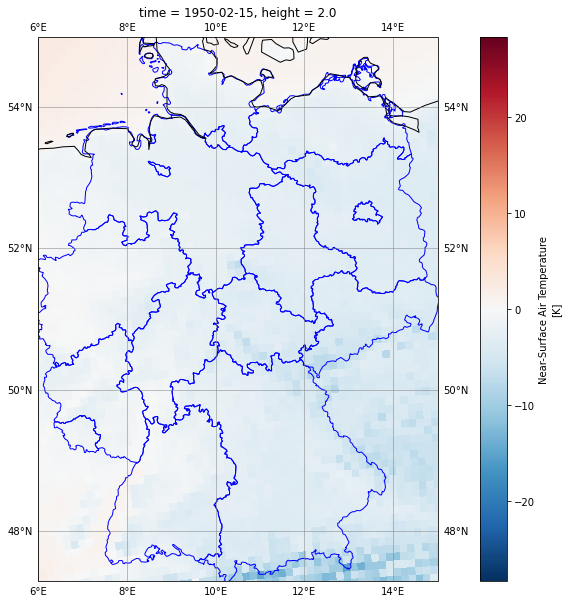

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
germany_bb = [5.98865807458, 15.0169958839, 47.3024876979,  54.983104153]
plt.figure(figsize=(15,10))
projection = ccrs.PlateCarree()
rotated = ccrs.RotatedPole(pole_latitude=pole[1], pole_longitude=pole[0])
ax = plt.axes(projection=projection)
#ax.set_aspect(2.0)
ax.set_extent(germany_bb, crs=projection)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      xlocs=range(-180,180,2), ylocs=range(-90,90,2))
(ds.tas-273.5).isel(time=0).plot(ax=ax, transform=rotated, x='rlon', y='rlat')
ax.coastlines(resolution='50m', color='black', linewidth=1)
regs.plot(ax=ax, edgecolor="b", facecolor="none", transform=projection)
#ax.add_feature(cf.BORDERS)

### Example Data: Compute annual change

We define a simple function to compute annual change between two datasets:

In [11]:
def annual_change(ref_ds, ds):
    reference = ref_ds.mean(dim="time")
    return ds.groupby("time.year").mean(dim="time") - reference

Now, let's look at annual change of rcp85 scnenario at the end of the century (2080-2100) with respect to mean of the historical period (1970-2000).

In [12]:
change = annual_change(hist.sel(time=slice("1970", "2000")), scen.sel(time=slice("2080", "2100")))

In [13]:
%time change_ = change.compute()

CPU times: user 741 ms, sys: 312 ms, total: 1.05 s
Wall time: 2.16 s


In [14]:
change_

<xarray.Dataset>
Dimensions:                     (rlat: 412, rlon: 424, vertices: 4, year: 21)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
    lat                         (rlat, rlon) float32 21.99 22.03 ... 66.75 66.69
    lon                         (rlat, rlon) float32 349.9 350.0 ... 64.76 64.96
    height                      float64 2.0
  * year                        (year) int64 2080 2081 2082 ... 2098 2099 2100
Dimensions without coordinates: vertices
Data variables:
    rotated_latitude_longitude  (year) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat_vertices                (year, rlat, rlon, vertices) float32 0.0 ... 0.0
    lon_vertices                (year, rlat, rlon, vertices) float32 0.0 ... 0.0
    tas                         (year, rlat, rlon) float32 4.077 4.076 ... 6.499

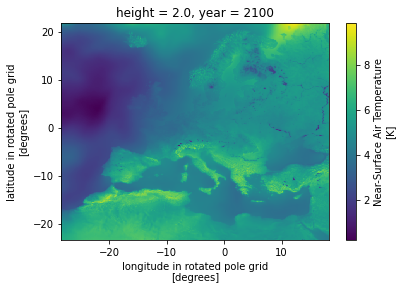

In [15]:
change.sel(year=2100).tas.plot()

## Regridding

We are interested in local information on the Bundesländer scale. We use a conservative regridding approach to compute the mask weights using xesmf. However, the CORDEX datasets don't really have reliable meta information on grid bounds, e.g, for this example, we have to shift the `lon_vertics` and `lat_vertices` so they are CF conform (see also [here](https://nbviewer.org/github/larsbuntemeyer/notebooks/blob/main/vertices-order.ipynb)).

In [16]:
# wrong order of vertices in the cmorized dataset
ds = ds.roll(vertices=-1, roll_coords=True)

In [17]:
import xesmf as xe
%time savg = xe.SpatialAverager(ds, regs.geometry, geom_dim_name="federal_state")

CPU times: user 12.6 s, sys: 397 ms, total: 13 s
Wall time: 13.4 s


In [18]:
savg

xESMF SpatialAverager 
Weight filename:            spatialavg_412x424_16.nc 
Reuse pre-computed weights? False 
Input grid shape:           (412, 424) 
Output list length:         16 

Now, let's apply the averager instance to our datasets of annual change.

In [19]:
out = savg(change.tas)
out = out.assign_coords(federal_state=xr.DataArray(regs["name"], dims=("federal_state",)))
out

<xarray.DataArray (year: 21, federal_state: 16)>
dask.array<getitem, shape=(21, 16), dtype=float32, chunksize=(1, 16), chunktype=numpy.ndarray>
Coordinates:
    height         float64 2.0
  * year           (year) int64 2080 2081 2082 2083 2084 ... 2097 2098 2099 2100
    lon            (federal_state) float64 10.01 9.16 8.742 ... 11.7 11.03 9.811
    lat            (federal_state) float64 53.55 52.77 53.2 ... 52.01 50.9 54.18
  * federal_state  (federal_state) object '02_Hamburg' ... '01_Schleswig-Hols...
Attributes:
    regrid_method:  conservative

We compute the temporial mean for the last 20 years of the centure and capture the result in a new colum of the geodataframe.

In [20]:
regs["field_avg"] = out.mean(dim="year").values
regs

,ADE,ARS,ARS_0,GEN,geometry,name,field_avg
0,2,02,020000000000,Hamburg,"MULTIPOLYGON (((10.19113 53.72299, 10.18209 53...",02_Hamburg,3.380658
1,2,03,030000000000,Niedersachsen,"MULTIPOLYGON (((6.80525 53.59771, 6.80398 53.5...",03_Niedersachsen,3.402578
2,2,04,040000000000,Bremen,"MULTIPOLYGON (((8.52975 53.21639, 8.55399 53.2...",04_Bremen,3.319681
3,2,05,050000000000,Nordrhein-Westfalen,"POLYGON ((8.66673 52.52148, 8.70289 52.50052, ...",05_Nordrhein-Westfalen,3.396694
4,2,06,060000000000,Hessen,"POLYGON ((9.50561 51.62776, 9.50843 51.62712, ...",06_Hessen,3.585046
5,2,07,070000000000,Rheinland-Pfalz,"POLYGON ((7.84659 50.87860, 7.85903 50.87733, ...",07_Rheinland-Pfalz,3.520653
6,2,08,080000000000,Baden-Württemberg,"MULTIPOLYGON (((8.66979 47.68564, 8.66565 47.6...",08_Baden-Württemberg,3.735612
7,2,09,090000000000,Bayern,"POLYGON ((10.45456 47.55586, 10.47205 47.56964...",09_Bayern,3.749865
8,2,10,100000000000,Saarland,"POLYGON ((7.06854 49.62350, 7.08025 49.61197, ...",10_Saarland,3.481460
9,2,11,110000000000,Berlin,"POLYGON ((13.61191 52.54331, 13.62460 52.53797...",11_Berlin,3.623530


Lets' have a look.

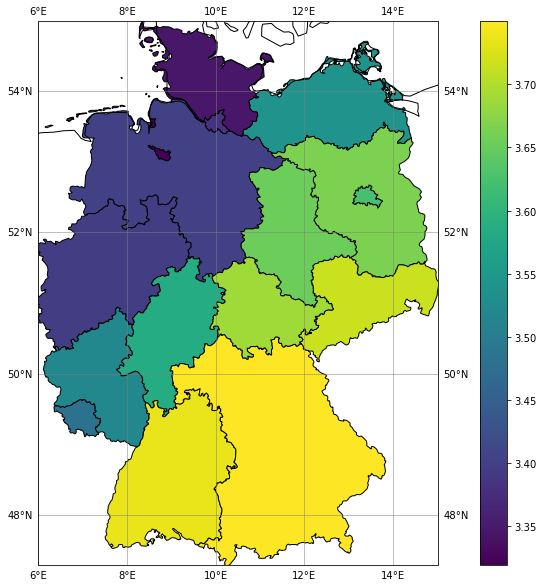

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
projection = ccrs.PlateCarree()
rotated = ccrs.RotatedPole(pole_latitude=pole[1], pole_longitude=pole[0])
ax = plt.axes(projection=projection)
#ax.set_aspect(2.0)
ax.set_extent(germany_bb, crs=projection)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      xlocs=range(-180,180,2), ylocs=range(-90,90,2))
#(ds.tas-273.5).isel(time=0).plot(ax=ax, transform=rotated, x='rlon', y='rlat')
ax.coastlines(resolution='50m', color='black', linewidth=1)
#ax.add_feature(cf.BORDERS, linewidth=2, color='r')
handles = regs.plot(column="field_avg", ax=ax, edgecolor="k", legend=True)

In [22]:
savg.weights.data.nbytes / 1.e6

0.07332

## Check out the mask

Let's have a look at the masks we created. We need to convert the sparse regridding matrix into a numpy dataarray.

In [23]:
import numpy as np
w = xr.DataArray(
    np.array(savg.weights).reshape(regs.geometry.size, *ds.lon.shape),
    dims=("federal_state", *ds.lon.dims),
    coords=dict(federal_state=out.federal_state, **ds.lon.coords),
)

In [24]:
w.nbytes / 1.e6

22.360064

In [25]:
w.federal_state

<xarray.DataArray 'federal_state' (federal_state: 16)>
array(['02_Hamburg', '03_Niedersachsen', '04_Bremen', '05_Nordrhein-Westfalen',
       '06_Hessen', '07_Rheinland-Pfalz', '08_Baden-Württemberg', '09_Bayern',
       '10_Saarland', '11_Berlin', '12_Brandenburg',
       '13_Mecklenburg-Vorpommern', '14_Sachsen', '15_Sachsen-Anhalt',
       '16_Thüringen', '01_Schleswig-Holstein'], dtype=object)
Coordinates:
  * federal_state  (federal_state) object '02_Hamburg' ... '01_Schleswig-Hols...
    height         float64 2.0

<GeoAxesSubplot:title={'center':'federal_state = 05_Nordrhein-Westfalen, height ...'}, xlabel='longitude in rotated pole grid\n[degrees]', ylabel='latitude in rotated pole grid\n[degrees]'>

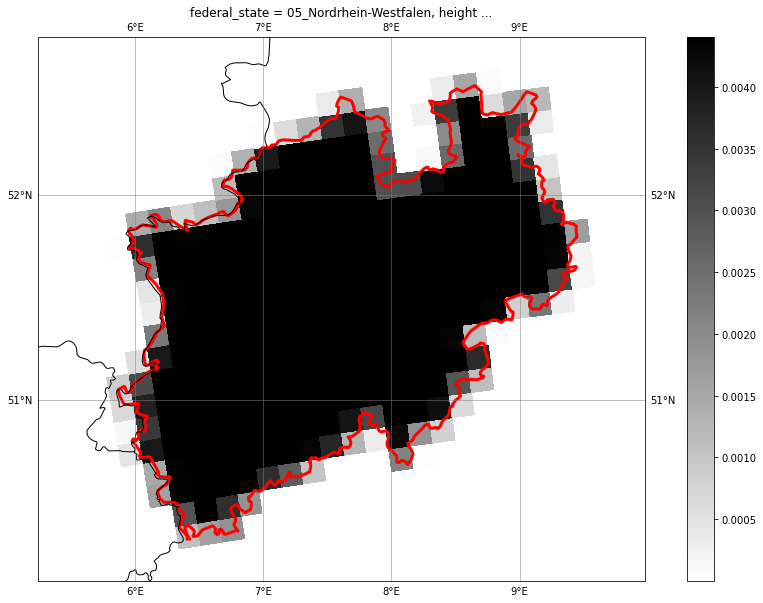

In [26]:
federal_state='05_Nordrhein-Westfalen'

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
               xlocs=range(-180,180,1), ylocs=range(-90,90,1))
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cf.BORDERS)
subregion = w.sel(federal_state=federal_state)
subregion.where(subregion > 0, drop=True).plot(ax=ax, transform=rotated, cmap='binary')
regs[regs.name == federal_state].plot(ax=ax, edgecolor="r", linewidth=3, facecolor="none", transform=ccrs.PlateCarree())

We can check that the weight sums accumulate to unity as they should:

In [27]:
w.sum(dim=["rlon", "rlat"]).values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [28]:
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known
Tot = len(w.federal_state)
Cols = 4
# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols
# Create a Position index
Position = range(1,Tot + 1)

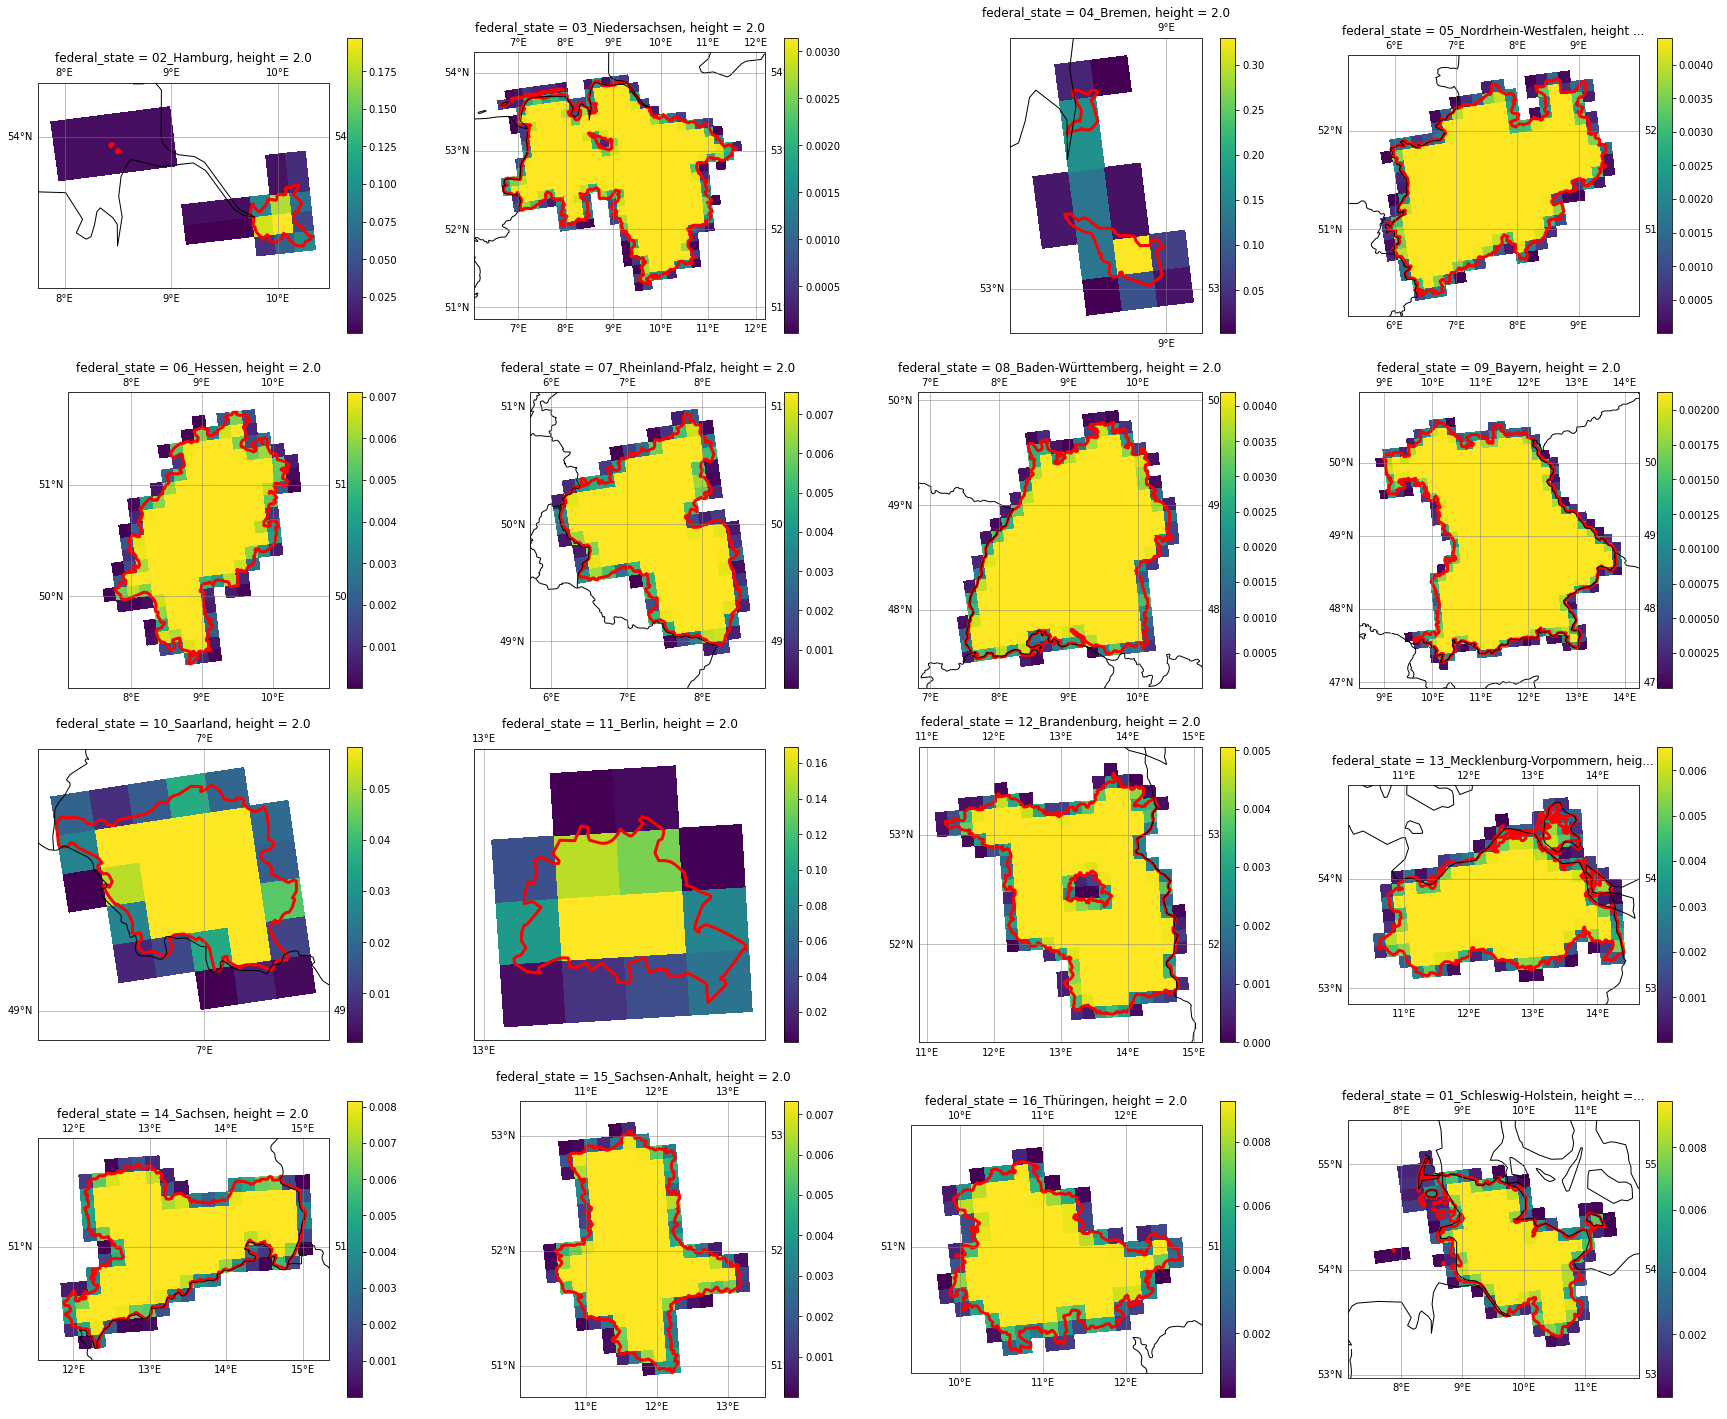

In [29]:
# Create main figure
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 25))
rotated = ccrs.RotatedPole(*pole)
proj = ccrs.PlateCarree()

for k in range(Tot):  
  # add every single subplot to the figure with a for loop
  ax = fig.add_subplot(Rows,Cols,Position[k], projection=proj)
  ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
               xlocs=range(-180,180,1), ylocs=range(-90,90,1))
  ax.coastlines(resolution='50m', color='black', linewidth=1)
  ax.add_feature(cf.BORDERS)
  subregion = w.isel(federal_state=k)
  subregion.where(subregion > 0, drop=True).plot(ax=ax, transform=rotated)
  regs[regs.name == str(subregion.federal_state.values)].plot(ax=ax, edgecolor="r", linewidth=3, facecolor="none", transform=ccrs.PlateCarree())

## Landkreis Scale

In [30]:
regs = cx.regions.germany.geodataframe('krs')

Let's plot an overview

<GeoAxesSubplot:title={'center':'time = 1950-02-15, height = 2.0'}, xlabel='longitude in rotated pole grid\n[degrees]', ylabel='latitude in rotated pole grid\n[degrees]'>

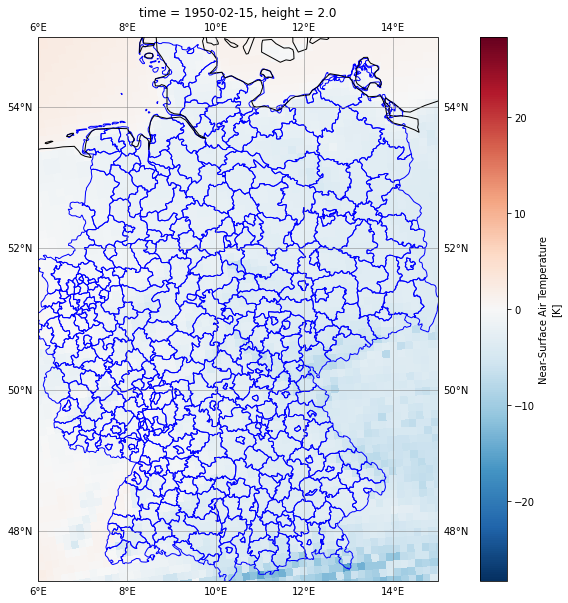

In [31]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
germany_bb = [5.98865807458, 15.0169958839, 47.3024876979,  54.983104153]
plt.figure(figsize=(15,10))
projection = ccrs.PlateCarree()
transform = ccrs.RotatedPole(pole_latitude=pole[1], pole_longitude=pole[0])
ax = plt.axes(projection=projection)
#ax.set_aspect(2.0)
ax.set_extent(germany_bb, crs=projection)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      xlocs=range(-180,180,2), ylocs=range(-90,90,2))
(ds.tas-273.5).isel(time=0).plot(ax=ax, transform=transform, x='rlon', y='rlat')
ax.coastlines(resolution='50m', color='black', linewidth=1)
regs.plot(ax=ax, edgecolor="b", facecolor="none", transform=projection)

In [32]:
import xesmf as xe
%time savg = xe.SpatialAverager(ds, regs.geometry, geom_dim_name="country")

CPU times: user 14.5 s, sys: 242 ms, total: 14.7 s
Wall time: 14.3 s


In [33]:
savg

xESMF SpatialAverager 
Weight filename:            spatialavg_412x424_401.nc 
Reuse pre-computed weights? False 
Input grid shape:           (412, 424) 
Output list length:         401 

In [34]:
out = savg(change.tas)
out = out.assign_coords(country=xr.DataArray(regs["name"], dims=("country",)))
out

<xarray.DataArray (year: 21, country: 401)>
dask.array<getitem, shape=(21, 401), dtype=float32, chunksize=(1, 401), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * year     (year) int64 2080 2081 2082 2083 2084 ... 2096 2097 2098 2099 2100
    lon      (country) float64 9.44 10.13 10.73 9.983 ... 11.74 11.71 12.07 12.4
    lat      (country) float64 54.79 54.33 53.87 54.08 ... 50.58 50.75 50.96
  * country  (country) object '01001_Flensburg' ... '16077_Altenburger Land'
Attributes:
    regrid_method:  conservative

In [35]:
regs["field_avg"] = out.mean(dim="year").values
regs

,ADE,ARS,ARS_0,GEN,geometry,name,field_avg
0,4,01001,010010000000,Flensburg,"POLYGON ((9.48979 54.82296, 9.50464 54.81003, ...",01001_Flensburg,3.283291
1,4,01002,010020000000,Kiel,"POLYGON ((10.19056 54.38909, 10.18368 54.38910...",01002_Kiel,3.362138
2,4,01003,010030000000,Lübeck,"POLYGON ((10.89297 53.95695, 10.90337 53.95705...",01003_Lübeck,3.447886
3,4,01004,010040000000,Neumünster,"POLYGON ((10.03453 54.12914, 10.02276 54.10937...",01004_Neumünster,3.400945
4,4,01051,010510000000,Dithmarschen,"MULTIPOLYGON (((8.68759 54.05943, 8.69257 54.0...",01051_Dithmarschen,3.276058
...,...,...,...,...,...,...,...
396,4,16073,160730000000,Saalfeld-Rudolstadt,"POLYGON ((11.32074 50.79488, 11.32374 50.79445...",16073_Saalfeld-Rudolstadt,3.710382
397,4,16074,160740000000,Saale-Holzland-Kreis,"POLYGON ((12.01806 50.96757, 12.02085 50.94807...",16074_Saale-Holzland-Kreis,3.742952
398,4,16075,160750000000,Saale-Orla-Kreis,"POLYGON ((11.94482 50.59237, 11.92423 50.58608...",16075_Saale-Orla-Kreis,3.675838
399,4,16076,160760000000,Greiz,"POLYGON ((12.22218 50.94284, 12.23786 50.92905...",16076_Greiz,3.728521


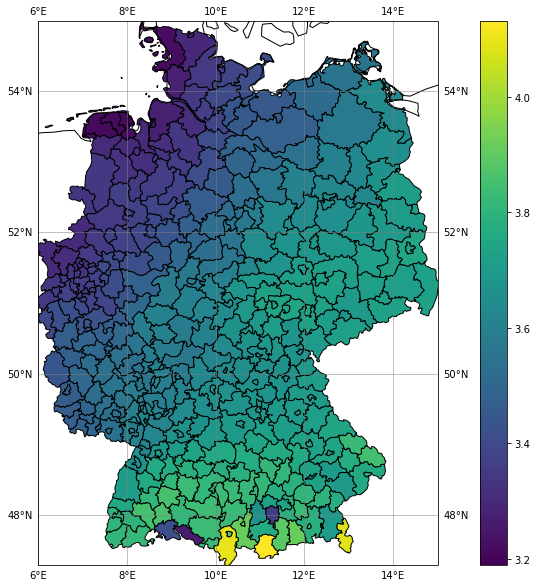

In [36]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
projection = ccrs.PlateCarree()
transform = ccrs.RotatedPole(pole_latitude=pole[1], pole_longitude=pole[0])
ax = plt.axes(projection=projection)
#ax.set_aspect(2.0)
ax.set_extent(germany_bb, crs=projection)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      xlocs=range(-180,180,2), ylocs=range(-90,90,2))
#(ds.tas-273.5).isel(time=0).plot(ax=ax, transform=transform, x='rlon', y='rlat')
ax.coastlines(resolution='50m', color='black', linewidth=1)
handles = regs.plot(column="field_avg", ax=ax, edgecolor="k", legend=True)

In [37]:
import numpy as np
w = xr.DataArray(
    np.array(savg.weights).reshape(regs.geometry.size, *ds.lon.shape),
    dims=("country", *ds.lon.dims),
    coords=dict(country=out.country, **ds.lon.coords),
)

<GeoAxesSubplot:title={'center':'country = 13076_Ludwigslust-Parchim, height = 2.0'}, xlabel='longitude in rotated pole grid\n[degrees]', ylabel='latitude in rotated pole grid\n[degrees]'>

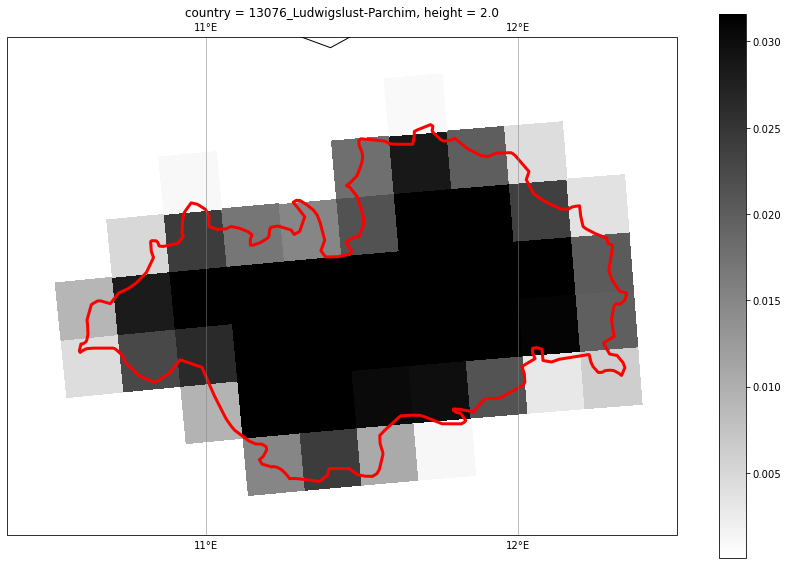

In [38]:
country='13076_Ludwigslust-Parchim'

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
               xlocs=range(-180,180,1), ylocs=range(-90,90,1))
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cf.BORDERS)
subregion = w.sel(country=country)
subregion.where(subregion > 0, drop=True).plot(ax=ax, transform=rotated, cmap='binary')
regs[regs.name == country].plot(ax=ax, edgecolor="r", linewidth=3, facecolor="none", transform=ccrs.PlateCarree())